In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.utils.data as data

from state_inference.env import ObservationModel, TransitionModel
from state_inference.model import (
    Encoder, Decoder, StateVae, DEVICE, TransitionPredictor, PomdpModel
    )
from state_inference.data import PomdpDataset
from state_inference.pytorch_utils import train_epochs


In [3]:
import sys

print(f"python {sys.version}")
print(f"torch {torch.__version__}")
print(f"device = {DEVICE}")

python 3.9.16 (main, Mar  8 2023, 04:29:24) 
[Clang 14.0.6 ]
torch 2.0.0
device = mps


### Generate the task

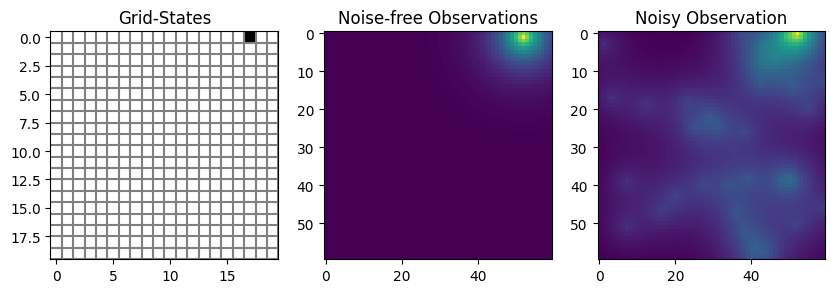

In [4]:
# Discritized states: a 20x20 grid of states, which we embed by spacing
# evenly in a nXn space
HEIGHT, WIDTH = 20, 20
MAP_HEIGHT = 60


gw_kwargs = dict(
    rbf_kernel_size=51, rbf_kernel_scale=0.2, location_noise_scale=1.0  # must be odd
)


observation_model = ObservationModel(HEIGHT, WIDTH, MAP_HEIGHT, **gw_kwargs)
transition_model = TransitionModel(HEIGHT, WIDTH)


# show an example location
s = 17
observation_model.display_state(s)

### Generate the training / test datasets

In [5]:
### Simulation Parameters
N_TRAINING_EXAMPLES = 10000
N_TEST_EXAMPLES = 2000
BATCH_SIZE = 64

# Create the dataloaders from the dataset
args = [transition_model, observation_model]
train_obs = PomdpDataset(*args, N_TRAINING_EXAMPLES, n_chains=10)
test_obs = PomdpDataset(*args, N_TEST_EXAMPLES)

train_loader = data.DataLoader(
    train_obs,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
test_loader = data.DataLoader(test_obs, batch_size=BATCH_SIZE)

### Define the model

In [6]:
### Model + Training Parameters
N_EPOCHS = 20  # should be 20
EMBEDDING_LAYERS = 5
EMBEDDING_DIM = len(observation_model.states) // 2
OBSERVATION_DIM = observation_model.map_height**2
LR = 3e-4
beta = 2.0
tau = 1.0
gamma = 0.95
dropout = 0.01

# create the model
z_dim = EMBEDDING_DIM * EMBEDDING_LAYERS
encoder_hidden = [OBSERVATION_DIM // 5, OBSERVATION_DIM // 10]
decoder_hidden = [OBSERVATION_DIM // 10, OBSERVATION_DIM // 5]
transition_hidden = [z_dim * 2, z_dim * 2]

encoder = Encoder(
    OBSERVATION_DIM,
    encoder_hidden,
    z_dim,
    dropout=dropout,
)
decoder = Decoder(
    z_dim,
    decoder_hidden,
    OBSERVATION_DIM,
    dropout=dropout,
)

vae_kwargs = dict(
    z_dim=EMBEDDING_DIM, z_layers=EMBEDDING_LAYERS, beta=beta, tau=tau, gamma=gamma
)

observation_model = StateVae(encoder, decoder, **vae_kwargs).to(DEVICE)

In [7]:
def preprocess_fn(batch_data):
    x, _ = batch_data
    return x


train_losses, test_losses = train_epochs(
    observation_model,
    train_loader,
    test_loader,
    dict(epochs=N_EPOCHS, lr=LR, clip_grad=True),
    preprocess=preprocess_fn,
)

Epoch 0, ELBO Loss (test) 6.127101
Epoch 1, ELBO Loss (test) 4.516454
Epoch 2, ELBO Loss (test) 3.643970
Epoch 3, ELBO Loss (test) 3.022479
Epoch 4, ELBO Loss (test) 2.687285
Epoch 5, ELBO Loss (test) 2.132742
Epoch 6, ELBO Loss (test) 1.716232
Epoch 7, ELBO Loss (test) 1.423679
Epoch 8, ELBO Loss (test) 1.310467
Epoch 9, ELBO Loss (test) 1.176267
Epoch 10, ELBO Loss (test) 1.092476
Epoch 11, ELBO Loss (test) 0.971803
Epoch 12, ELBO Loss (test) 0.942998
Epoch 13, ELBO Loss (test) 0.849642
Epoch 14, ELBO Loss (test) 0.737170
Epoch 15, ELBO Loss (test) 0.649400
Epoch 16, ELBO Loss (test) 0.643753
Epoch 17, ELBO Loss (test) 0.704564
Epoch 18, ELBO Loss (test) 0.656058
Epoch 19, ELBO Loss (test) 0.605331


In [10]:
forward_model = TransitionPredictor(
    transition_hidden, z_dim=EMBEDDING_DIM, z_layers=EMBEDDING_LAYERS
).to(DEVICE)

reverse_model = TransitionPredictor(
    transition_hidden, z_dim=EMBEDDING_DIM, z_layers=EMBEDDING_LAYERS
).to(DEVICE)

pomdp = PomdpModel(observation_model, forward_model, reverse_model)

train_losses, test_losses = train_epochs(
    pomdp,
    train_loader,
    test_loader,
    dict(epochs=N_EPOCHS, lr=LR, clip_grad=True),
)
# print(transition_model)

Epoch 0, ELBO Loss (test) 0.000253
Epoch 1, ELBO Loss (test) 0.000100
Epoch 2, ELBO Loss (test) 0.000068
Epoch 3, ELBO Loss (test) 0.000070
Epoch 4, ELBO Loss (test) 0.000084
Epoch 5, ELBO Loss (test) 0.000039
Epoch 6, ELBO Loss (test) 0.000049
Epoch 7, ELBO Loss (test) 0.000036
Epoch 8, ELBO Loss (test) 0.000058
Epoch 9, ELBO Loss (test) 0.000037
Epoch 10, ELBO Loss (test) 0.000088
Epoch 11, ELBO Loss (test) 0.000051
Epoch 12, ELBO Loss (test) 0.000053
Epoch 13, ELBO Loss (test) 0.000043
Epoch 14, ELBO Loss (test) 0.000040
Epoch 15, ELBO Loss (test) 0.000038
Epoch 16, ELBO Loss (test) 0.000100
Epoch 17, ELBO Loss (test) 0.000050
Epoch 18, ELBO Loss (test) 0.000036
Epoch 19, ELBO Loss (test) 0.000038


In [11]:
pomdp.get_forward_state_estimate

<bound method PomdpModel.get_forward_state_estimate of PomdpModel(
  (observation_model): StateVae(
    (encoder): Encoder(
      (net): Sequential(
        (0): Linear(in_features=3600, out_features=720, bias=True)
        (1): BatchNorm1d(720, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Dropout(p=0.01, inplace=False)
        (3): ReLU()
        (4): Linear(in_features=720, out_features=360, bias=True)
        (5): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Dropout(p=0.01, inplace=False)
        (7): ReLU()
        (8): Linear(in_features=360, out_features=1000, bias=True)
        (9): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (decoder): Decoder(
      (net): Sequential(
        (0): Linear(in_features=1000, out_features=360, bias=True)
        (1): BatchNorm1d(360, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Dro